Firstly let's test how the network from lab works.

# Recommender Systems with Graph Neural Networks in PyG

By Derrick Li, Peter Maldonado, Akram Sbaih as part of the Stanford CS224W course project.

In this tutorial, we implement two GNN recommender system architectures, LightGCN and NGCF, in PyG and apply them to the MovieLens 100K dataset.

## Setup

First, we'll install the necessary packages.

In [71]:
%%capture
# Environment Setup (note that capture silences the console output)
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
# !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# !git clone https://github.com/pmaldonado/cs224w-project-data.git

%pip install ipywidgets
%jupyter nbextension enable --py widgetsnbextension

Next, let's import all of the modules that we'll use in this notebook.

In [72]:
# Standard library imports
import random
import os

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', None)

import torch
import torch.nn as nn
import torch.nn.functional as F
# from torch.utils.data import Dataset, DataLoader
import torch_geometric
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import degree

from tqdm.notebook import tqdm
from sklearn import preprocessing as pp

Lastly, we should double check that our environment is working as expected.

In [73]:
torch_geometric.__version__

'2.4.0'

In [74]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [75]:
model_path = '../models/'

## Load preprocessed dataset

In [76]:
columns_name=['index','user_id','item_id','rating','timestamp']
train_df = pd.read_csv("../data/interim/train-20-core.csv", index_col=0, sep=",", names=columns_name, header=0)
test_df = pd.read_csv("../data/interim/test-20-core.csv", index_col=0, sep=",", names=columns_name, header=0)

In [77]:
train_df.head()

,user_id,item_id,rating,timestamp
index,,,,
40158,354,513,4,875745631
20601,531,158,5,882956761
23791,514,157,4,885844395
41313,779,693,5,888478882
15089,237,227,4,875742437


In [78]:
print("Train Size  : ", len(train_df))
print("Test Size : ", len (test_df))

Train Size  :  36374
Test Size :  10393


Since we performed the train/test randomly on the interactions, not all users and items may be present in the training set. We will relabel all of users and items to ensure the highest label is the number of users and items, respectively.

In [79]:
le_user = pp.LabelEncoder()
le_item = pp.LabelEncoder()
train_df['user_id_idx'] = le_user.fit_transform(train_df['user_id'].values)
train_df['item_id_idx'] = le_item.fit_transform(train_df['item_id'].values)

In [80]:
train_user_ids = train_df['user_id'].unique()
train_item_ids = train_df['item_id'].unique()

print(len(train_user_ids), len(train_item_ids))

test_df = test_df[
  (test_df['user_id'].isin(train_user_ids)) & \
  (test_df['item_id'].isin(train_item_ids))
]
print(len(test_df))

845 811
10393


In [81]:
test_df['user_id_idx'] = le_user.transform(test_df['user_id'].values)
test_df['item_id_idx'] = le_item.transform(test_df['item_id'].values)

In [82]:
n_users = train_df['user_id_idx'].nunique()
n_items = train_df['item_id_idx'].nunique()
print("Number of Unique Users : ", n_users)
print("Number of unique Items : ", n_items)

Number of Unique Users :  845
Number of unique Items :  811


### Minibatch Sampling

Explain the scheme of minibatch positive and negative sample in some amount of prose.

We need to add `n_usr` to the sampled positive and negative items, since each node must have a unique id when using PyG.

In [83]:
def data_loader(data, batch_size, n_usr, n_itm):

    def sample_neg(x):
        while True:
            neg_id = random.randint(0, n_itm - 1)
            if neg_id not in x:
                return neg_id

    interected_items_df = data.groupby('user_id_idx')['item_id_idx'].apply(list).reset_index()
    indices = [x for x in range(n_usr)]

    if n_usr < batch_size:
        users = [random.choice(indices) for _ in range(batch_size)]
    else:
        users = random.sample(indices, batch_size)
    users.sort()
    users_df = pd.DataFrame(users,columns = ['users'])

    interected_items_df = pd.merge(interected_items_df, users_df, how = 'right', left_on = 'user_id_idx', right_on = 'users')
    pos_items = interected_items_df['item_id_idx'].apply(lambda x : random.choice(x)).values
    neg_items = interected_items_df['item_id_idx'].apply(lambda x: sample_neg(x)).values

    return (
        torch.LongTensor(list(users)).to(device), 
        torch.LongTensor(list(pos_items)).to(device) + n_usr, 
        torch.LongTensor(list(neg_items)).to(device) + n_usr
    )

data_loader(train_df, 16, n_users, n_items)

(tensor([  9,  58,  60, 179, 180, 269, 374, 455, 481, 490, 514, 556, 568, 604,
         723, 815], device='cuda:0'),
 tensor([ 977, 1080,  889, 1095, 1005, 1166, 1352, 1322, 1433, 1041, 1004, 1501,
         1080, 1131,  975, 1000], device='cuda:0'),
 tensor([1321, 1584, 1180,  978, 1276,  871, 1022,  847, 1522, 1568, 1439, 1377,
         1161, 1096, 1075, 1287], device='cuda:0'))

## Edge Index

PyG represents graphs as sparse lists of node pairs. Since our graph is undirected, we need to include each edge twice, once for the edges from the users to the items and vice-versa.

Similar to above, we add `n_users` to the item tensor to ensure that every node in the graph has a unique identifier.

In [84]:
u_t = torch.LongTensor(train_df.user_id_idx)
i_t = torch.LongTensor(train_df.item_id_idx) + n_users

train_edge_index = torch.stack((
  torch.cat([u_t, i_t]),
  torch.cat([i_t, u_t])
)).to(device)
train_edge_index

tensor([[ 354,  531,  514,  ..., 1203,  932, 1028],
        [1358, 1003, 1002,  ...,  442,  240,  768]], device='cuda:0')

Let's confirm that the first and last edges match the middle two edges, but with the order of nodes swapped.

In [85]:
train_edge_index[:,-1], train_edge_index[:, 0]

(tensor([1028,  768], device='cuda:0'), tensor([ 354, 1358], device='cuda:0'))

In [86]:
train_edge_index[:, len(train_df)-1], train_edge_index[:, len(train_df)]

(tensor([ 768, 1028], device='cuda:0'), tensor([1358,  354], device='cuda:0'))

## Model Architecture

First, let's take a look at the graph convolutional layers that will power our recommender system GNN. Then, we can implement a wrapper to stack multiple convolutional layers.

### LightGCN Convolutional Layer

The LightGCN architecture is governed by the following rules:

$$e_{u}^{(k+1)} = \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}e^{(k)}_i$$

$$e_{i}^{(k+1)} = \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}e^{(k)}_u$$
In essence, the embedding for each node after a single LightGCN layer is the sum of the synthetic normalized embeddings of it's neighbors before the layer.


Briefly explain how the `MessagePassing` class works (look at colabs)

We can specify the type of aggregation our `MessagePassing` layer should use by passing in an `aggr=` argument in the layer initialization. Here we use `add` to specify summation aggregation of messages.

Note that we could have manually defined our aggregation function by defining a function explicitly in the class:
```
def aggregate(self, x, messages, index):
  return torch_scatter.scatter(messages, index, self.node_dim, reduce="sum")
```
The `torch_scatter.scatter` function enables us to aggregate messages being sent to the same node. The `reduce=` argument specifies how to aggregate, while `index` has the same length as the `messages` tensor and maps from message to destination node.

In [87]:
class LightGCNConv(MessagePassing):
  def __init__(self, **kwargs):
    super().__init__(aggr='add')

  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages (no update after aggregation)
    return self.propagate(edge_index, x=x, norm=norm)

  def message(self, x_j, norm):
    return norm.view(-1, 1) * x_j

Let's test out our implementation of the LightGCN convolution by applying it to a small bipartite graph.

This sample graph is undirected, and node 0 is connected to nodes 2 and 3 while node 1 is connected to 3 and 4.

In [88]:
test_x = torch.Tensor(np.eye(5))
test_edge_index = torch.LongTensor(np.array([
  [0, 0, 1, 1, 2, 3, 3, 4],
  [2, 3, 3, 4, 0, 0, 1, 1]
]))

LightGCNConv()(test_x, test_edge_index)

tensor([[0.0000, 0.0000, 0.7071, 0.5000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.5000, 0.7071],
        [0.7071, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.7071, 0.0000, 0.0000, 0.0000]])

Notice how each node has an initial feature vector corresponding to a one-hot encoding at the index of their id.

As we expected, node 0 received messages (and so has non-zero features at the corresponding indicies) from nodes 2 and 3. We can easily verify that nodes 1, 2, 3, and 4 also received messages from their precisely neighbors.

### NGCF Layer

NGCF is an older architecture than LightGCN that originated by researchers who applied [Graph Convolutional Networks (GCNs)]() to recommender systems. LightGCN functions the same as NGCF, but removes the learnable linear layers, non-linear activation, and dropout.

One layer of NGCF updates user and item embeddings as follows:

$$e_{u}^{(k+1)} = \sigma\left(W_1 e_u^{(k)} + \sum\limits_{i \in N_u} \frac{1}{\sqrt{|N_u|}\sqrt{|N_i|}}(W_1e^{(k)}_i + W_2(e^{(k)}_i \odot e^{(k)}_u))\right)$$

$$e_{i}^{(k+1)} = \sigma\left(W_1 e_i^{(k)} + \sum\limits_{u \in N_i} \frac{1}{\sqrt{|N_i|}\sqrt{|N_u|}}(W_1e^{(k)}_u + W_2(e^{(k)}_u \odot e^{(k)}_i))\right)$$

Typically, NGCF is implemented with dropout before the activation and with an activation function $\sigma$ of LeakyReLU.

In [89]:
class NGCFConv(MessagePassing):
  def __init__(self, latent_dim, dropout, bias=True, **kwargs):
    super(NGCFConv, self).__init__(aggr='add', **kwargs)

    self.dropout = dropout

    self.lin_1 = nn.Linear(latent_dim, latent_dim, bias=bias)
    self.lin_2 = nn.Linear(latent_dim, latent_dim, bias=bias)

    self.init_parameters()


  def init_parameters(self):
    nn.init.xavier_uniform_(self.lin_1.weight)
    nn.init.xavier_uniform_(self.lin_2.weight)


  def forward(self, x, edge_index):
    # Compute normalization
    from_, to_ = edge_index
    deg = degree(to_, x.size(0), dtype=x.dtype)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
    norm = deg_inv_sqrt[from_] * deg_inv_sqrt[to_]

    # Start propagating messages
    out = self.propagate(edge_index, x=(x, x), norm=norm)

    # Perform update after aggregation
    out += self.lin_1(x)
    out = F.dropout(out, self.dropout, self.training)
    return F.leaky_relu(out)


  def message(self, x_j, x_i, norm):
    return norm.view(-1, 1) * (self.lin_1(x_j) + self.lin_2(x_j * x_i))

### Recommender System GNN

For this tutorial, we will be using the following class, `RecSysGNN` in order to stack the NGCF or LightGCN convolutional layers. Some considerations that can be made for tweaking the models are the number of layers of your model and dropout. The more number of layers you add to the model, the more your model will "diffuse" information of recommendations made from nodes that are `n`-hops away in a model that uses `n` layers. Dropout can be tweaked to try out different regularization schemes.

Notice that our forward function works differently from most neural networks by forward propagating embeddings for all nodes in the graph. This is because the embeddings for a given node depend on the embeddings of it's `n`-hop neighborhood, so they need to be propagated as well.

In [90]:
class RecSysGNN(nn.Module):
  def __init__(
      self,
      latent_dim,
      num_layers,
      num_users,
      num_items,
      model, # 'NGCF' or 'LightGCN'
      dropout=0.1 # Only used in NGCF
  ):
    super(RecSysGNN, self).__init__()

    assert (model == 'NGCF' or model == 'LightGCN'), \
        'Model must be NGCF or LightGCN'
    self.model = model
    self.embedding = nn.Embedding(num_users + num_items, latent_dim)

    if self.model == 'NGCF':
      self.convs = nn.ModuleList(
        NGCFConv(latent_dim, dropout=dropout) for _ in range(num_layers)
      )
    else:
      self.convs = nn.ModuleList(LightGCNConv() for _ in range(num_layers))

    self.init_parameters()


  def init_parameters(self):
    if self.model == 'NGCF':
      nn.init.xavier_uniform_(self.embedding.weight, gain=1)
    else:
      # Authors of LightGCN report higher results with normal initialization
      nn.init.normal_(self.embedding.weight, std=0.1)


  def forward(self, edge_index):
    emb0 = self.embedding.weight
    embs = [emb0]

    emb = emb0
    for conv in self.convs:
      emb = conv(x=emb, edge_index=edge_index)
      embs.append(emb)

    out = (
      torch.cat(embs, dim=-1) if self.model == 'NGCF'
      else torch.mean(torch.stack(embs, dim=0), dim=0)
    )

    return emb0, out


  def encode_minibatch(self, users, pos_items, neg_items, edge_index):
    emb0, out = self(edge_index)
    return (
        out[users],
        out[pos_items],
        out[neg_items],
        emb0[users],
        emb0[pos_items],
        emb0[neg_items]
    )

## Loss function and metrics

We implement both the Bayesian Personalized Ranking loss function for a single minibatch of users, positive items, and negative items, as well as the precision@K and recall@K metrics.

In [91]:
def compute_bpr_loss(users, users_emb, pos_emb, neg_emb, user_emb0,  pos_emb0, neg_emb0):
  # compute loss from initial embeddings, used for regulization
  reg_loss = (1 / 2) * (
    user_emb0.norm().pow(2) +
    pos_emb0.norm().pow(2)  +
    neg_emb0.norm().pow(2)
  ) / float(len(users))

  # compute BPR loss from user, positive item, and negative item embeddings
  pos_scores = torch.mul(users_emb, pos_emb).sum(dim=1)
  neg_scores = torch.mul(users_emb, neg_emb).sum(dim=1)

  bpr_loss = torch.mean(F.softplus(neg_scores - pos_scores))

  return bpr_loss, reg_loss

In [92]:
def get_metrics(user_Embed_wts, item_Embed_wts, n_users, n_items, train_data, test_data, K):
  test_user_ids = torch.LongTensor(test_data['user_id'].unique())
  # compute the score of all user-item pairs
  relevance_score = torch.matmul(user_Embed_wts, torch.transpose(item_Embed_wts,0, 1))

  # create dense tensor of all user-item interactions
  i = torch.stack((
    torch.LongTensor(train_df['user_id'].values),
    torch.LongTensor(train_df['item_id'].values)
  ))
  v = torch.ones((len(train_df)), dtype=torch.float64)
  interactions_t = torch.sparse.FloatTensor(i, v, (n_users, n_items))\
      .to_dense().to(device)

  # mask out training user-item interactions from metric computation
  relevance_score = torch.mul(relevance_score, (1 - interactions_t))

  # compute top scoring items for each user
  topk_relevance_indices = torch.topk(relevance_score, K).indices
  topk_relevance_indices_df = pd.DataFrame(topk_relevance_indices.cpu().numpy(),columns =['top_indx_'+str(x+1) for x in range(K)])
  topk_relevance_indices_df['user_ID'] = topk_relevance_indices_df.index
  topk_relevance_indices_df['top_rlvnt_itm'] = topk_relevance_indices_df[['top_indx_'+str(x+1) for x in range(K)]].values.tolist()
  topk_relevance_indices_df = topk_relevance_indices_df[['user_ID','top_rlvnt_itm']]

  # measure overlap between recommended (top-scoring) and held-out user-item
  # interactions
  test_interacted_items = test_data.groupby('user_id')['item_id'].apply(list).reset_index()
  metrics_df = pd.merge(test_interacted_items,topk_relevance_indices_df, how= 'left', left_on = 'user_id',right_on = ['user_ID'])
  metrics_df['intrsctn_itm'] = [list(set(a).intersection(b)) for a, b in zip(metrics_df.item_id, metrics_df.top_rlvnt_itm)]

  metrics_df['recall'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/len(x['item_id']), axis = 1)
  metrics_df['precision'] = metrics_df.apply(lambda x : len(x['intrsctn_itm'])/K, axis = 1)

  return metrics_df['recall'].mean(), metrics_df['precision'].mean()

## Train and evaluate models

Now that we've implemented both LightGCN and NGCF in PyG, we can train and evaluate their performance!

In [93]:
latent_dim = 64
n_layers = 3

EPOCHS = 50
BATCH_SIZE = 1024
DECAY = 0.0001
LR = 0.005
K = 20

In [94]:
def train_and_eval(model, optimizer, train_df):
  loss_list_epoch = []
  bpr_loss_list_epoch = []
  reg_loss_list_epoch = []

  recall_list = []
  precision_list = []

  for epoch in tqdm(range(EPOCHS)):
      n_batch = int(len(train_df)/BATCH_SIZE)

      final_loss_list = []
      bpr_loss_list = []
      reg_loss_list = []

      model.train()
      for batch_idx in range(n_batch):

          optimizer.zero_grad()

          users, pos_items, neg_items = data_loader(train_df, BATCH_SIZE, n_users, n_items)
          users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0 = model.encode_minibatch(users, pos_items, neg_items, train_edge_index)

          bpr_loss, reg_loss = compute_bpr_loss(
            users, users_emb, pos_emb, neg_emb, userEmb0,  posEmb0, negEmb0
          )
          reg_loss = DECAY * reg_loss
          final_loss = bpr_loss + reg_loss

          final_loss.backward()
          optimizer.step()

          final_loss_list.append(final_loss.item())
          bpr_loss_list.append(bpr_loss.item())
          reg_loss_list.append(reg_loss.item())

      model.eval()
      with torch.no_grad():
          _, out = model(train_edge_index)
          final_user_Embed, final_item_Embed = torch.split(out, (n_users, n_items))
          test_topK_recall,  test_topK_precision = get_metrics(
            final_user_Embed, final_item_Embed, n_users, n_items, train_df, test_df, K
          )

      loss_list_epoch.append(round(np.mean(final_loss_list),4))
      bpr_loss_list_epoch.append(round(np.mean(bpr_loss_list),4))
      reg_loss_list_epoch.append(round(np.mean(reg_loss_list),4))

      recall_list.append(round(test_topK_recall,4))
      precision_list.append(round(test_topK_precision,4))

  return (
    loss_list_epoch,
    bpr_loss_list_epoch,
    reg_loss_list_epoch,
    recall_list,
    precision_list
  )

### Train and eval LightGCN

In [95]:
lightgcn = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='LightGCN'
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([1656, 64])]


In [96]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(lightgcn, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [98]:
torch.save(lightgcn.state_dict(), os.path.join(model_path, f'lightgcn/eval_model.pt'))
torch.save(optimizer.state_dict(), os.path.join(model_path, f'lightgcn/optimizer.pt'))

In [99]:
epoch_list = [(i+1) for i in range(EPOCHS)]

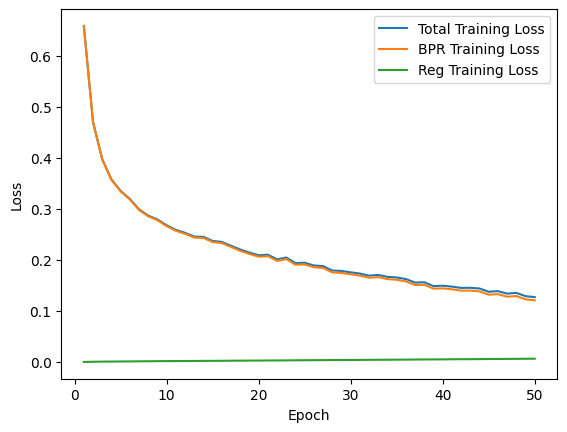

In [100]:
plt.plot(epoch_list, light_loss, label='Total Training Loss')
plt.plot(epoch_list, light_bpr, label='BPR Training Loss')
plt.plot(epoch_list, light_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

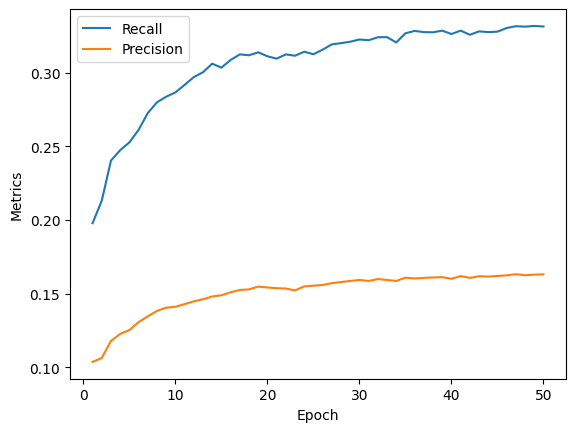

In [101]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Train and eval NGCF

In [102]:
ngcf = RecSysGNN(
  latent_dim=latent_dim,
  num_layers=n_layers,
  num_users=n_users,
  num_items=n_items,
  model='NGCF'
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([1656, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [103]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(ngcf, optimizer, train_df)

  0%|          | 0/50 [00:00<?, ?it/s]

In [104]:
torch.save(ngcf.state_dict(), os.path.join(model_path, f'ngcf/eval_model.pt'))
torch.save(optimizer.state_dict(), os.path.join(model_path, f'ngcf/optimizer.pt'))

In [105]:
epoch_list = [(i+1) for i in range(EPOCHS)]

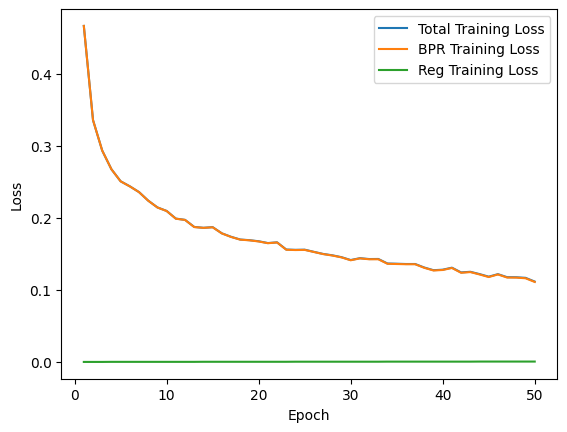

In [106]:
plt.plot(epoch_list, ngcf_loss, label='Total Training Loss')
plt.plot(epoch_list, ngcf_bpr, label='BPR Training Loss')
plt.plot(epoch_list, ngcf_reg, label='Reg Training Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

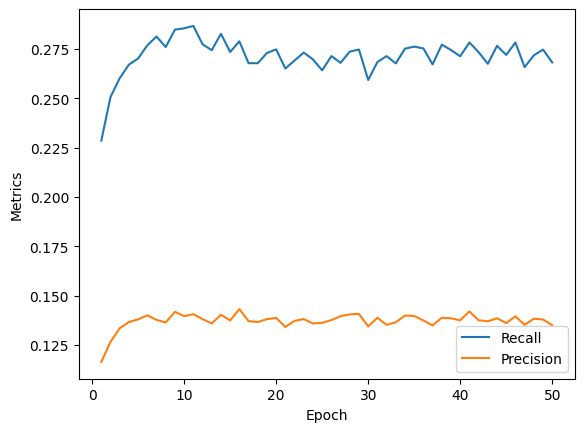

In [107]:
plt.plot(epoch_list, ngcf_recall, label='Recall')
plt.plot(epoch_list, ngcf_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

### Compare model performance

In [108]:
max(light_precision), max(light_recall)

(0.1632, 0.3316)

Values on unprocessed data: (0.2431, 0.3647)

rating > 3: (0.1909, 0.333)

rating >= 3: (0.2126, 0.3347)

In [109]:
max(ngcf_precision), max(ngcf_recall)

(0.1432, 0.2867)

Values on unprocessed data:  (0.2108, 0.3113)

rating > 3: (0.1681, 0.2966)

rating >= 3: (0.1864, 0.2943)

Exclusion of users with 

## Paper References

1. Harper, F. Maxwell, and Konstan, Joseph A. “The MovieLensDatasets: History and Context.” ACM Transactions on Interactive Intelligence Systems (TiiS) 5, 4. 2015.
2. He, Xiangnan, et al. “LightGCN: Simplifying and powering graph convolution network for recommendation.” Proceedings of the 43rd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2020.
3. Wang, Xiang, et al. “Neural graph collaborative filtering.” Proceedings of the 42nd International ACM SIGIR Conference on Research and Development in Information Retrieval. 2019.

## Code References

We thank the authors of the following codebases and notebooks, from which parts of this tutorial were inspired or adapted.

- https://www.kaggle.com/dipanjandas96/lightgcn-pytorch-from-scratch

- https://github.com/gusye1234/LightGCN-PyTorch

- https://github.com/SytzeAndr/NGCF_RP32/blob/hand-in/NGCF.ipynb
